In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Đồ án biểu diễn (Dự báo giá chứng khoán)/dataset/VNM.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-01,20.879999,20.980000,20.750000,20.799999,20.696852,195600
1,2021-12-02,20.799999,20.850000,20.680000,20.719999,20.617249,296800
2,2021-12-03,20.500000,20.549999,20.280001,20.370001,20.268986,251000
3,2021-12-06,20.000000,20.049999,19.870001,20.010000,19.910770,502800
4,2021-12-07,20.379999,20.559999,20.320000,20.510000,20.408291,339700


In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.931326
1,0.923800
2,0.890875
3,0.857008
4,0.904045


In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [ ]:
def position_encoding(inputs):
    T = tf.shape(input=inputs)[1]
    repr_dim = inputs.get_shape()[-1]
    pos = tf.reshape(tf.range(0.0, tf.cast(T, dtype=tf.float32), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(input=inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(x=inputs, axes=[-1], keepdims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.compat.v1.get_variable('gamma', params_shape, tf.float32, tf.compat.v1.ones_initializer())
    beta = tf.compat.v1.get_variable('beta', params_shape, tf.float32, tf.compat.v1.zeros_initializer())
    return gamma * normalized + beta

def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(input=x)[0], pad_sz, hidden_dim])
    x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          dilation_rate = dilation_rate)
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        kernel_size = 3,
        n_attn_heads = 16,
        dropout = 0.9,
    ):
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
        encoder_embedded += position_encoding(encoder_embedded)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate
            with tf.compat.v1.variable_scope('block_%d'%i):
                encoder_embedded += cnn_block(encoder_embedded, dilation_rate,
                                              pad_sz, size_layer, kernel_size)

        encoder_output, output_memory = encoder_embedded, encoder_embedded + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate
            with tf.compat.v1.variable_scope('decode_%d'%i):
                attn_res = h = cnn_block(encoder_embedded, dilation_rate,
                                         pad_sz, size_layer, kernel_size)

            C = []
            for j in range(n_attn_heads):
                h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.compat.v1.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.compat.v1.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.compat.v1.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(a=zu_, perm=[0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.compat.v1.layers.dense(attn_res + c, size_layer)
            h = tf.nn.dropout(h, rate = 1 - (dropout))
            encoder_embedded += h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = test_size
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 5e-4

In [ ]:
def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1],
        dropout = dropout_rate
    )
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
            )
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


<ipython-input-13-c86594444c39>:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
<ipython-input-13-c86594444c39>:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
<ipython-input-13-c86594444c39>:67: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:68: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:69: UserWarning: `tf.layers.dense` 

simulation 2


<ipython-input-13-c86594444c39>:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
<ipython-input-13-c86594444c39>:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
<ipython-input-13-c86594444c39>:67: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:68: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:69: UserWarning: `tf.layers.dense` 

simulation 3


<ipython-input-13-c86594444c39>:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
<ipython-input-13-c86594444c39>:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
<ipython-input-13-c86594444c39>:67: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:68: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:69: UserWarning: `tf.layers.dense` 

simulation 4


<ipython-input-13-c86594444c39>:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
<ipython-input-13-c86594444c39>:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
<ipython-input-13-c86594444c39>:67: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:68: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:69: UserWarning: `tf.layers.dense` 

simulation 5


<ipython-input-13-c86594444c39>:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
<ipython-input-13-c86594444c39>:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
<ipython-input-13-c86594444c39>:67: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:68: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:69: UserWarning: `tf.layers.dense` 

simulation 6


<ipython-input-13-c86594444c39>:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
<ipython-input-13-c86594444c39>:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
<ipython-input-13-c86594444c39>:67: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:68: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:69: UserWarning: `tf.layers.dense` 

simulation 7


<ipython-input-13-c86594444c39>:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
<ipython-input-13-c86594444c39>:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
<ipython-input-13-c86594444c39>:67: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:68: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:69: UserWarning: `tf.layers.dense` 

simulation 8


<ipython-input-13-c86594444c39>:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
<ipython-input-13-c86594444c39>:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
<ipython-input-13-c86594444c39>:67: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:68: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:69: UserWarning: `tf.layers.dense` 

simulation 9


<ipython-input-13-c86594444c39>:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
<ipython-input-13-c86594444c39>:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
<ipython-input-13-c86594444c39>:67: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:68: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:69: UserWarning: `tf.layers.dense` 

simulation 10


<ipython-input-13-c86594444c39>:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
<ipython-input-13-c86594444c39>:21: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
<ipython-input-13-c86594444c39>:67: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:68: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
<ipython-input-13-c86594444c39>:69: UserWarning: `tf.layers.dense` 

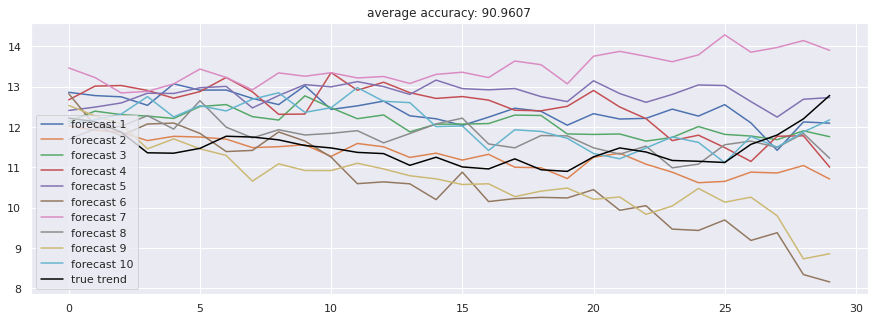

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()